# Initialization

Run the following code to import the modules you'll need. After your finish the assignment, **remember to run all cells** and save the note book to your local machine as a PDF for gradescope submission.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Download data

In this section we will download the data and setup the paths.


In [3]:
# Download the data
if not os.path.exists('bead_data.npz'):
    !wget https://www.cs.cmu.edu/~deva/data/bead_data.npz -O bead_data.npz

if not os.path.exists('hammer_handle_data.npz'):
    !wget https://www.cs.cmu.edu/~deva/data/hammer_handle_data.npz -O hammer_handle_data.npz

We provide the following helper function, which computes the rotation matrix from the parameterization θ and its derivative with respect to rotation component of θ.

In [ ]:
"""
Helper Functions
"""

def get_dR_dtheta_xyz(theta_x, theta_y, theta_z):
    """
    Compute parital derivatives of the rotation matrix R = Rz(theta_z) @ Ry(theta_y) @ Rx(theta_x) wrt theta_x, theta_y, theta_z.

    :param[float] theta_x               : x element of x-y-z Euler Rotation.
    :param[float] theta_y               : y element of x-y-z Euler Rotation.
    :param[float] theta_z               : z element of x-y-z Euler Rotation.
    :return
        [np.array (3, 3)] dR_dtheta_x   : The partial derivative of the rotation matrix with regards to theta_x.
        [np.array (3, 3)] dR_dtheta_y   : The partial derivative of the rotation matrix with regards to theta_y.
        [np.array (3, 3)] dR_dtheta_z   : The partial derivative of the rotation matrix with regards to theta_z.
    """
    cx, cy, cz = np.cos(theta_x), np.cos(theta_y), np.cos(theta_z)
    sx, sy, sz = np.sin(theta_x), np.sin(theta_y), np.sin(theta_z)

    # Rotation matrices
    Rx = np.array([
        [1, 0, 0],
        [0, cx, -sx],
        [0, sx, cx]
    ])
    Ry = np.array([
        [cy, 0, sy],
        [0, 1, 0],
        [-sy, 0, cy]
    ])
    Rz = np.array([
        [cz, -sz, 0],
        [sz,  cz, 0],
        [0,   0,  1]
    ])

    # Derivatives of Rx wrt x
    dRx_dx = np.array([
        [0, 0, 0],
        [0, -sx, -cx],
        [0, cx, -sx]
    ])
    # Derivatives of Ry wrt y
    dRy_dy = np.array([
        [-sy, 0, cy],
        [0, 0, 0],
        [-cy, 0, -sy]
    ])
    # Derivatives of Rz wrt z
    dRz_dz = np.array([
        [-sz, -cz, 0],
        [cz, -sz, 0],
        [0, 0, 0]
    ])

    # Chain rule for full R = Rz * Ry * Rx
    dR_dx = Rz @ Ry @ dRx_dx
    dR_dy = Rz @ dRy_dy @ Rx
    dR_dz = dRz_dz @ Ry @ Rx

    return dR_dx, dR_dy, dR_dz

def get_R(theta_x, theta_y, theta_z):
    """
    Compute the rotation matrix R = Rz(theta_z) @ Ry(theta_y) @ Rx(theta_x).

    :param[float] theta_x        : x element of x-y-z Euler Rotation.
    :param[float] theta_y        : y element of x-y-z Euler Rotation.
    :param[float] theta_z        : z element of x-y-z Euler Rotation.
    :return[np.array (3, 3)] R   : The rotation matrix.
    """
    cx, cy, cz = np.cos(theta_x), np.cos(theta_y), np.cos(theta_z)
    sx, sy, sz = np.sin(theta_x), np.sin(theta_y), np.sin(theta_z)

    # Rotation matrices
    Rx = np.array([
        [1, 0, 0],
        [0, cx, -sx],
        [0, sx, cx]
    ])
    Ry = np.array([
        [cy, 0, sy],
        [0, 1, 0],
        [-sy, 0, cy]
    ])
    Rz = np.array([
        [cz, -sz, 0],
        [sz,  cz, 0],
        [0,   0,  1]
    ])
    R = Rz @ Ry @ Rx
    return R


# Q5.2: Implement NormalFlow (15 points)
Make sure to comment your code and use proper names for your variables.

In [ ]:
from scipy.interpolate import RectBivariateSpline
from numpy.linalg import lstsq

def NormalFlow(It, It1, Ht, Ht1, Ct, Ct1, max_iters=20, rot_threshold=0.0001, trans_threshold=0.1, init_theta=np.zeros(5)):
    """
    :param[np.array(H, W, 3)] It   : Normal Map at time t [float]
    :param[np.array(H, W, 3)] It1  : Normal Map at time t+1 [float]
    :param[np.array(H, W)] Ht      : Height Map at time t, unit: pixel [float]
    :param[np.array(H, W)] Ht1     : Height Map at time t+1, unit: pixel [float]
    :param[np.array(H, W)] Ct      : Contact Mask at time t [bool]
    :param[np.array(H, W)] Ct1     : Contact Mask at time t+1 [bool]
    :param[int] max_iters          : Max number of optimization iterations
    :param[float] rot_threshold    : If change in rotation parameters is less than thresh, terminate the optimization
    :param[float] trans_threshold  : If change in translation parameters is less than thresh, terminate the optimization
    :param[np.array(5)] init_theta : The initial parameter
    :return[np.array(4, 4)] t1_T_t : The Homogeneous transformation matrix of the object from frame t to frame t+1
    """
    # Initialize theta to zeros
    theta = init_theta.copy()

    # ===== your code here! =====
    # Hint: Iterate over max_iters and for each iteration, construct a linear system (Ax=b) that solves for a x=delta_theta update
    # Construct [A] by computing image gradients at (possibly fractional) pixel locations and for each channel
    # It might be easier to consider compute the gradient over each element of theta independently
    # For each iteration, we suggest to first compute the warped pixel, then compute the shared contact mask, finally construct the linear system
    # We suggest using RectBivariateSpline from scipy.interpolate to interpolate pixel values at fractional pixel locations
    # We suggest using lstsq from numpy.linalg to solve the linear system
    # Once you solve for [delta_theta], add it to [theta] (and move on to next iteration)
    # Use the following termination condition:
    #
    # if (np.linalg.norm(delta_theta[:3]) < rot_threshold and np.linalg.norm(delta_theta[3:]) < trans_threshold):
    #     break
    #
    # HINT/WARNING:
    # RectBivariateSpline and Meshgrid use inconsistent defaults with respect to 'xy' versus 'ij' indexing:
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.RectBivariateSpline.ev.html#scipy.interpolate.RectBivariateSpline.ev
    # https://numpy.org/doc/stable/reference/generated/numpy.meshgrid.html


    # ===== End of code =====
    return theta

## Debug Q5.2

Debugging NormalFlow can be challenging. We provide the ground-truth object pose (in $\theta$) between frame 90 and frame 0 in the code below. You can use this to verify your implementation. Below are some tips for debugging:

- **Warping function**: Plot $\;I_{t+1}(\mathbf{W}(x; \theta))\;$ and $\;\mathbf{R}_{\theta} I_t(x)\;$, masked with the shared mask $\bar{C}$. If your implementation is correct, the two should match. A helper function below is provided to convert a normal map into an RGB image.

- **Gradient of the warped image**: Once you have a correct implementation of $\;I_{t+1}(\mathbf{W}(x; \theta))\;$, compute its numerical derivative  
  $\;\big(I_{t+1}(\mathbf{W}(x; \theta+d\theta)) - I_{t+1}(\mathbf{W}(x; \theta))\big)/d\theta\;$ for each dimension of $\theta$. Plot the results and check if they match your implementation of $\;\nabla I_{t+1}(\mathbf{W}(x; \theta))\;$.

- **Gradient of the rotated image**: Use the same procedure to debug your implementation of $\;\nabla \mathbf{R}_{\theta} I_t(x)\;$.

- **Convergence with provided initialization**: If you use the provided $\theta$ as `init_theta`, NormalFlow should converge very quickly to a value very close to the ground-truth $\theta$.

- **Convergence plot**: Plot the iterations versus the norm of `delta_theta`. Your algorithm should show fast convergence.


In [ ]:
"""
Helper Functions
"""

def normal2image(I):
    """
    Given a normal map, turn it into an image and return that

    :param[np.array (H, W, 3)] I        : The Normal Map
    :return[np.array (H, W, 3)] image   : The image
    """
    image = (np.clip((I + 1.0) / 2.0, 0.0, 1.0) * 255).astype(np.uint8)
    return image

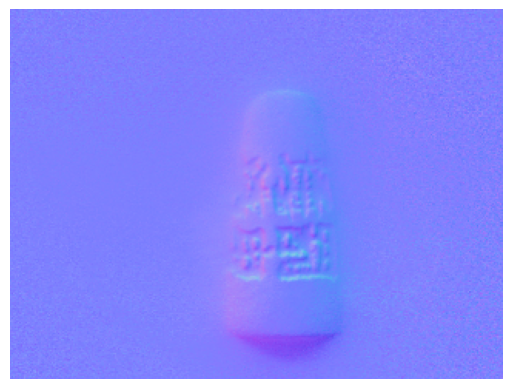

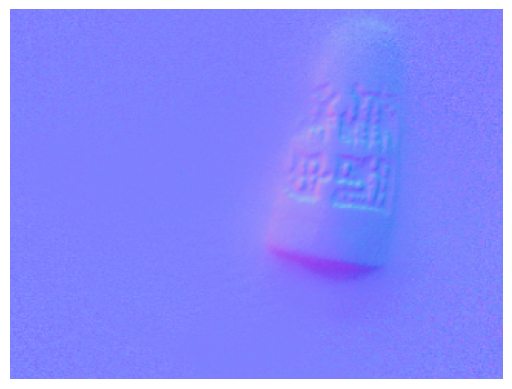

In [ ]:
# load the data
data_path = "bead_data.npz"
data = np.load(data_path, allow_pickle=True)
Cs = data["contact_masks"]
Is = data["normal_maps"]
Hs = data["height_maps"]

# We offer you the true object pose (in theta) of frame 90 relevant to frame 0
It = Is[0]; Ct = Cs[0]; Ht = Hs[0]
It1 = Is[90]; Ct1 = Cs[90]; Ht1 = Hs[90]
true_theta = [-0.00875, -0.00544, 0.15949, 43.419, -49.342]

# Plot the images
plt.imshow(normal2image(It))
plt.axis('off')
plt.show()
plt.imshow(normal2image(It1))
plt.axis('off')
plt.show()


## Q5.3: Tracking with NormalFlow (10 points)

Implement the tracking method that, given a sequence of tactile-derived local geometries, returns the object pose of each frame relative to the first frame in the form of a $4 \times 4$ homogeneous transformation matrix. A helper function is provided to convert $\theta$ into a homogeneous matrix. For convenience, this helper assumes zero translation along the $z$-axis, since the object remains in contact with the sensor.

In [ ]:
"""
Helper Functions
"""

def theta2T(theta):
    """
    Given the theta, assume zero z-translation, compute homogeneous transform matrix.

    :param[np.array (5)] theta        : The parameterization of the object transformation.
    :return[np.array (4, 4)] T        : The homogeneous transformation matrix.
    """
    T = np.eye(4, dtype=np.float32)
    T[:3, :3] = get_R(theta[0], theta[1], theta[2])
    T[0, 3] = theta[3]
    T[1, 3] = theta[4]
    return T

In [ ]:
def TrackSequence(Is, Hs, Cs):
    """
    :param[np.array(N, H, W, 3)] Is   : Normal Map sequence [float]
    :param[np.array(N, H, W)] Hs      : Height Map sequence, unit: pixel [float]
    :param[np.array(N, H, W)] Cs      : Contact Mask sequence [bool]
    :param[int] max_iters             : Max number of optimization iterations
    :param[float] rot_threshold       : If change in rotation parameters is less than thresh, terminate the optimization
    :param[float] trans_threshold     : If change in translation parameters is less than thresh, terminate the optimization
    :return:[np.array(N, 4, 4)] Ts    : object pose with regards to the first frame in the form of homogeneous transformation
    """
    init_T = np.eye(4, dtype=np.float32)
    Ts = [init_T.copy()]
    # Iterate over the car sequence and track the car
    for i in range(Is.shape[0] - 1):

        # ===== your code here! =====
        # TODO: add your code track the 6DoF pose of the object

        # ===== End of code =====

    Ts = np.stack(Ts, 0)
    assert Ts.shape == (Is.shape[0], 4, 4), f"Your output sequence {Ts.shape} is not ({Is.shape[0]}x{4}x{4})"
    return Ts

### Q5.3 (a) - Track Bead Sequence

Run the snippets below. If your implementations of NormalFlow and TrackSequence are correct, each normal image will show the correct estimated 6DoF object pose with an annotated coordinate frame. Feel free to experiment with the parameters in the code.

In [ ]:
"""
Helper Functions
"""

def display_normal_with_coordinate_system(I, T, center_ref, title, vector_scale=50):
    """
    Show the normal map annotating with the computed coordinate system
    :param[np.array(H, W, 3)] I     : Normal Map [float]
    :param[np.array(4, 4)] T        : The homogeneous transformation matrix
    :param[np.array(2)] center_ref  : The x-y origin of the reference frame (first frame)
    :param[float] vector_scale      : The size of the coordinate axis arrow
    """
    fig, ax = plt.subplots(figsize=(3,3))
    ax.imshow(normal2image(I))

    # Get the center and the unit_vector
    unit_vectors_ref = np.eye(3)[:, :2]
    center_3d_ref = np.array([(center_ref[0] - I.shape[1] / 2 + 0.5), (center_ref[1] - I.shape[0] / 2 + 0.5), 0])
    unit_vectors_3d_ref = np.eye(3)
    remapped_center_3d_ref = (
        np.dot(T[:3, :3], center_3d_ref) + T[:3, 3]
    )
    remapped_cx_ref = remapped_center_3d_ref[0] + I.shape[1] / 2 - 0.5
    remapped_cy_ref = remapped_center_3d_ref[1] + I.shape[0] / 2 - 0.5
    remapped_center_ref = np.array([remapped_cx_ref, remapped_cy_ref]).astype(
        np.int32
    )
    remapped_unit_vectors_ref = (
        np.dot(T[:3, :3], unit_vectors_3d_ref.T).T
    )[:, :2]

    # Annotate the origin
    ax.scatter(remapped_center_ref[0], remapped_center_ref[1], c="k", alpha=1, s=10, zorder=3)

    # Annotate the three axes
    colors = ["r", "g", "b"]
    for i in range(3):
        dx, dy = remapped_unit_vectors_ref[i] * vector_scale
        ax.arrow(
            remapped_center_ref[0], remapped_center_ref[1], dx, dy,
            head_width=6, head_length=6,
            fc=colors[i], ec=colors[i],
            linewidth=1, length_includes_head=True
        )

    ax.set_axis_off()
    ax.set_title(title)
    plt.show()

def visualize_track(Is, Ts, vis_seq=[0]):
    # Visualize tracks on a seuqence of a selected sequence
    ys, xs = np.nonzero(Cs[0])
    cx_ref = xs.mean()
    cy_ref = ys.mean()
    center_ref = np.array([cx_ref, cy_ref]).astype(np.int32)
    for idx in vis_seq:
        display_normal_with_coordinate_system(Is[idx], Ts[idx], center_ref, "Frame %d"%idx)

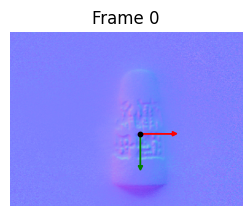

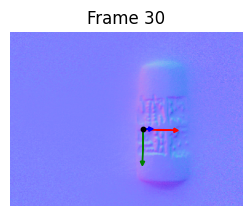

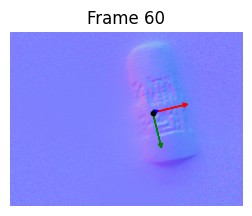

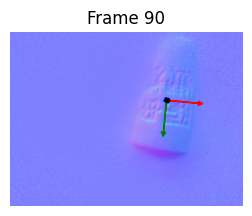

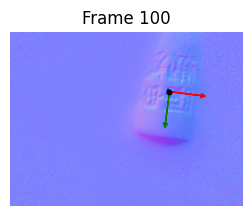

In [ ]:
# load the data
data_path = "bead_data.npz"
data = np.load(data_path, allow_pickle=True)
Cs = data["contact_masks"]
Is = data["normal_maps"]
Hs = data["height_maps"]

# Track the Bead
Ts = TrackSequence(Is, Hs, Cs)
# Visualize the tracking result
visualize_track(Is, Ts, [0, 30, 60, 90, 100])

### Q5.3 (b) - Track Hammer Handle Sequence

Track the handle of the hammer, which is made by wood.

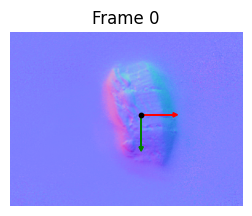

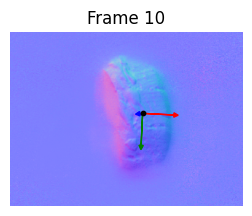

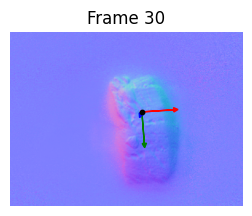

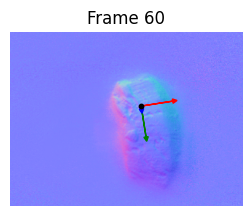

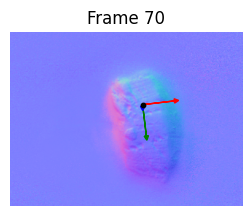

In [ ]:
# load the data
data_path = "hammer_handle_data.npz"
data = np.load(data_path, allow_pickle=True)
Cs = data["contact_masks"]
Is = data["normal_maps"]
Hs = data["height_maps"]

# Track the Hammer Handle
Ts = TrackSequence(Is, Hs, Cs)
# Visualize the tracking result
visualize_track(Is, Ts, [0, 10, 30, 60, 70])